# Stock Market Trend Predictions using Random Forests and Gradient Boosting

## Introduction
Stock market prediction is an incredibly difficult task, due to the randomness and noisiness found in the market. Yet, predicting market behaviors is a very important task. Correctly predicting stock price directions can be used to maximize profits, as well as to minimize risk. 

## Data
The data used for this project consists of regular stock data (open, close, volume, etc.) from Yahoo finance, and ranges from the year 2000 to 2018. From this data, technical indicators were calculated for every stock. Many investors use technical indicators to generate signals to trade on.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
from talib.abstract import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

## Data Preprocessing: Grab and Load Historical Price Data


In [2]:
start = datetime.datetime(1998, 1, 1)
#start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2016, 6, 30)
top_500 = ['AAPL','MSFT','COST','JNJ']

In [3]:
f = web.get_data_yahoo(top_500,start,end)
cleanData = f[['Adj Close','High','Low','Volume']]
stock_data = pd.DataFrame(cleanData)
stock_data.head()

Attributes Adj Close                                       High           \
Symbols         AAPL       COST        JNJ       MSFT      AAPL     COST   
Date                                                                       
1998-01-02  0.502414  16.005714  17.994564  10.487102  0.580357  22.3750   
1998-01-05  0.490820  16.324011  17.977280  10.427119  0.591518  22.5000   
1998-01-06  0.585505  15.960235  17.700714  10.487102  0.714286  22.4375   
1998-01-07  0.541061  15.801093  17.873569  10.362134  0.678571  22.1875   
1998-01-08  0.562317  16.301268  18.080997  10.437118  0.665179  22.6250   

Attributes                            Low                                 \
Symbols          JNJ       MSFT      AAPL      COST       JNJ       MSFT   
Date                                                                       
1998-01-02  32.59375  16.437500  0.482143  21.75000  32.31250  16.187500   
1998-01-05  32.71875  16.703125  0.542411  21.81250  32.21875  15.984375   
1998-01-06  32.34375  16.625000  0.526786  21.93750  31.68750  16.156250   
1998-01-07  32.31250  16.398438  0.618304  21.25000  31.75000  15.937500   
1998-01-08  32.90625  16.515625  0.604911  21.71875  32.28125  15.937500   

Attributes       Volume                                    
Symbols            AAPL       COST        JNJ        MSFT  
Date                                                       
1998-01-02  179527600.0  3451800.0  4656400.0  39748000.0  
1998-01-05  162968400.0  2167600.0  5308200.0  80377600.0  
1998-01-06  453118400.0  3376400.0  4971400.0  67834400.0  
1998-01-07  260405600.0  2829600.0  3768200.0  61492800.0  
1998-01-08  193505200.0  7284400.0  6087800.0  77619200.0

In [4]:
stocks = {}
for i in top_500:
    stocks[i] = web.get_data_yahoo(i,start,end)

In [5]:
for i,j in enumerate(stocks):
    stocks[j].columns = [s.lower() for s in stocks[j].columns]
    stocks[j].volume = stocks[j].volume.apply(lambda x: float(x))

## Data Preprocessing: Load the Data

In [6]:
stocks['COST'].head()

,high,low,open,close,volume,adj close
Date,,,,,,
1998-01-02,22.3750,21.75000,22.31250,22.00000,3451800.0,16.005714
1998-01-05,22.5000,21.81250,21.90625,22.43750,2167600.0,16.324011
1998-01-06,22.4375,21.93750,22.37500,21.93750,3376400.0,15.960235
1998-01-07,22.1875,21.25000,21.93750,21.71875,2829600.0,15.801093
1998-01-08,22.6250,21.71875,21.71875,22.40625,7284400.0,16.301268


In [7]:
stocks['COST'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4654 entries, 1998-01-02 to 2016-06-30
Data columns (total 6 columns):
high         4654 non-null float64
low          4654 non-null float64
open         4654 non-null float64
close        4654 non-null float64
volume       4654 non-null float64
adj close    4654 non-null float64
dtypes: float64(6)
memory usage: 254.5 KB


In [8]:
stocks['COST'].describe()

,high,low,open,close,volume,adj close
count,4654.000000,4654.000000,4654.000000,4654.000000,4.654000e+03,4654.000000
mean,66.636762,65.255954,65.938362,65.976239,3.818503e+06,53.177326
std,36.004317,35.755179,35.881064,35.894717,2.636948e+06,34.229855
min,21.750000,20.625000,21.093750,21.062500,1.033000e+05,15.323649
25%,40.405001,39.052500,39.724063,39.772500,2.234550e+06,28.975789
50%,53.720001,52.305000,53.014999,53.066250,3.253300e+06,39.647673
75%,83.675001,82.170002,83.009998,83.002502,4.704550e+06,65.669125
max,169.729996,165.869995,167.330002,168.869995,5.677350e+07,154.739960


In [9]:
stocks['JNJ'].head()

,high,low,open,close,volume,adj close
Date,,,,,,
1998-01-02,32.59375,32.31250,32.53125,32.53125,4656400.0,17.994564
1998-01-05,32.71875,32.21875,32.65625,32.50000,5308200.0,17.977280
1998-01-06,32.34375,31.68750,32.31250,32.00000,4971400.0,17.700714
1998-01-07,32.31250,31.75000,31.75000,32.31250,3768200.0,17.873569
1998-01-08,32.90625,32.28125,32.46875,32.68750,6087800.0,18.080997


In [10]:
stocks['JNJ'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4654 entries, 1998-01-02 to 2016-06-30
Data columns (total 6 columns):
high         4654 non-null float64
low          4654 non-null float64
open         4654 non-null float64
close        4654 non-null float64
volume       4654 non-null float64
adj close    4654 non-null float64
dtypes: float64(6)
memory usage: 254.5 KB


## Technical Indicators

I will use the TA-Lib python package to calculate technical indicators with their default parameters settings.

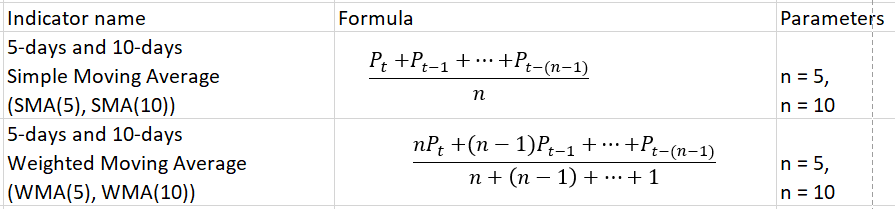

In [11]:
from IPython.display import Image
Image(filename='Desktop\pic.png') 

### Overlap Studies

$
\begin{align}
BBANDS: \ Bollinger \ Bands\
\end{align}
$

$
\begin{align}
SMA: \ Simple \ Moving \ Average
\end{align}
$

$
\begin{align}
WMA: \ Weighted \ Moving \ Average
\end{align}
$

### Momentum Indicators

$
\begin{align}
MOM: \ Momentum
\end{align}
$

$
\begin{align}
MACD: \ Moving \ Average \ Convergence \ Divergence
\end{align}
$

$
\begin{align}
RSI: \ Relative \ Strength \ Index
\end{align}
$

$
\begin{align}
WILLR: \ Williams' \ Percentage \ R
\end{align}
$

$
\begin{align}
CCI: \ Commodity \ Channel \ Index
\end{align}
$

$
\begin{align}
ADX: \ Average \ Directional \ Movement \ Index
\end{align}
$

### Volume Indicators


$
\begin{align}
ADOSC: \ Chaikin \ A/D \ Oscillator
\end{align}
$

$
\begin{align}
OBV: \ On \ Balance \ Volume
\end{align}
$

In [12]:
def get_indicators(stocks, period):
    stocks_indicators = {}
    for i in stocks:
        # Overlap Studies Functions : 
        features = pd.DataFrame(SMA(stocks[i], timeperiod=5))
        features.columns = ['sma_5']
        features['sma_10'] = pd.DataFrame(SMA(stocks[i], timeperiod=10))
        features['mom_10'] = pd.DataFrame(MOM(stocks[i],10))
        features['wma_10'] = pd.DataFrame(WMA(stocks[i],10))
        features['wma_5'] = pd.DataFrame(WMA(stocks[i],5))
        features = pd.concat([features,STOCHF(stocks[i], 
                                          fastk_period=14, 
                                          fastd_period=3)],
                             axis=1)
        features['macd'] = pd.DataFrame(MACD(stocks[i], fastperiod=12, slowperiod=26)['macd'])
        features['rsi'] = pd.DataFrame(RSI(stocks[i], timeperiod=14))
        features['willr'] = pd.DataFrame(WILLR(stocks[i], timeperiod=14))
        features['cci'] = pd.DataFrame(CCI(stocks[i], timeperiod=14))
        features['adosc'] = pd.DataFrame(ADOSC(stocks[i], fastperiod=3, slowperiod=10))
        features['atr'] = pd.DataFrame(ATR(stocks[i], timeperiod=14))
        features['adx'] = pd.DataFrame(ADX(stocks[i], timeperiod=14))
        features['obv'] = pd.DataFrame(OBV(stocks[i]))
        features['pct_change'] = ROC(stocks[i], timeperiod=period)
        features['pct_change'] = features['pct_change'].shift(-period)
        features['pct_change'] = features['pct_change'].apply(lambda x: '1' if x > 0 else '0' if x <= 0 else np.nan)
        features = features.dropna()
        features = features.iloc[np.where(features.index=='1998-5-5')[0][0]:np.where(features.index=='2015-5-5')[0][0]]
        stocks_indicators[i] = features
    return stocks_indicators

In [13]:
stocks_indicators = get_indicators(stocks, 1)

In [14]:
stocks_indicators['COST'].head()

,sma_5,sma_10,mom_10,wma_10,wma_5,fastk,fastd,macd,rsi,willr,cci,adosc,atr,adx,obv,pct_change
Date,,,,,,,,,,,,,,,,
1998-05-05,27.578125,27.748438,-1.109375,27.625000,27.644792,34.558824,47.303922,0.198341,49.625025,-65.441176,-67.670116,-93971.104572,0.782231,16.543499,43605600.0,1
1998-05-06,27.721875,27.667188,-0.812500,27.596875,27.650000,42.647059,43.872549,0.176328,51.157564,-57.352941,-43.736730,-127600.574436,0.753143,15.434051,45110000.0,0
1998-05-07,27.646875,27.564062,-1.031250,27.577841,27.596875,41.176471,39.460784,0.154580,50.854629,-58.823529,-2.533210,-716612.578068,0.757383,15.308247,43265600.0,1
1998-05-08,27.759375,27.598437,0.343750,27.725284,27.839583,79.411765,54.411765,0.200593,57.844259,-20.588235,42.424242,-466849.299730,0.774713,14.973738,44794200.0,0
1998-05-11,27.846875,27.701563,1.031250,27.849432,28.013542,75.000000,65.196078,0.226879,56.839744,-25.000000,83.656331,-430698.301973,0.748394,14.798436,43317000.0,0


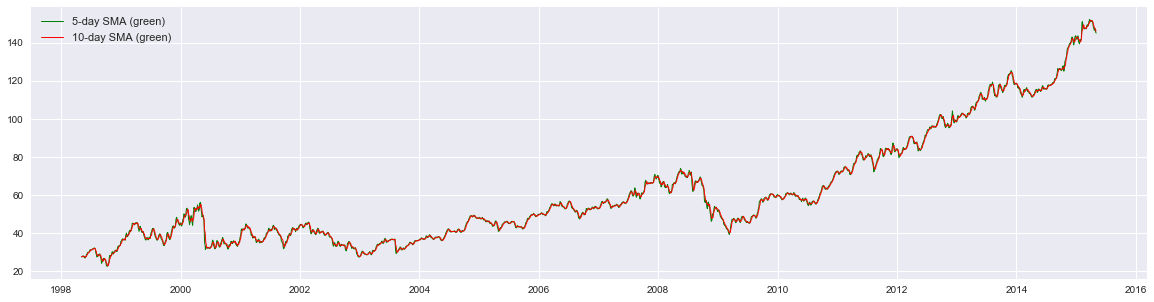

In [17]:
# Plotting the COST Price chart and Moving Averages below
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()


plt.figure(figsize=(20,5))
#plt.plot(stocks['COST']['close'],lw=1, label='COST Prices')
plt.plot(stocks_indicators['COST']['sma_5'],'g',lw=1, label='5-day SMA (green)')
plt.plot(stocks_indicators['COST']['sma_10'],'r',lw=1, label='10-day SMA (green)')
plt.legend(loc=2,prop={'size':11})
plt.grid(True)
#plt.setp(plt.gca().get_xticklabels(), rotation=30)

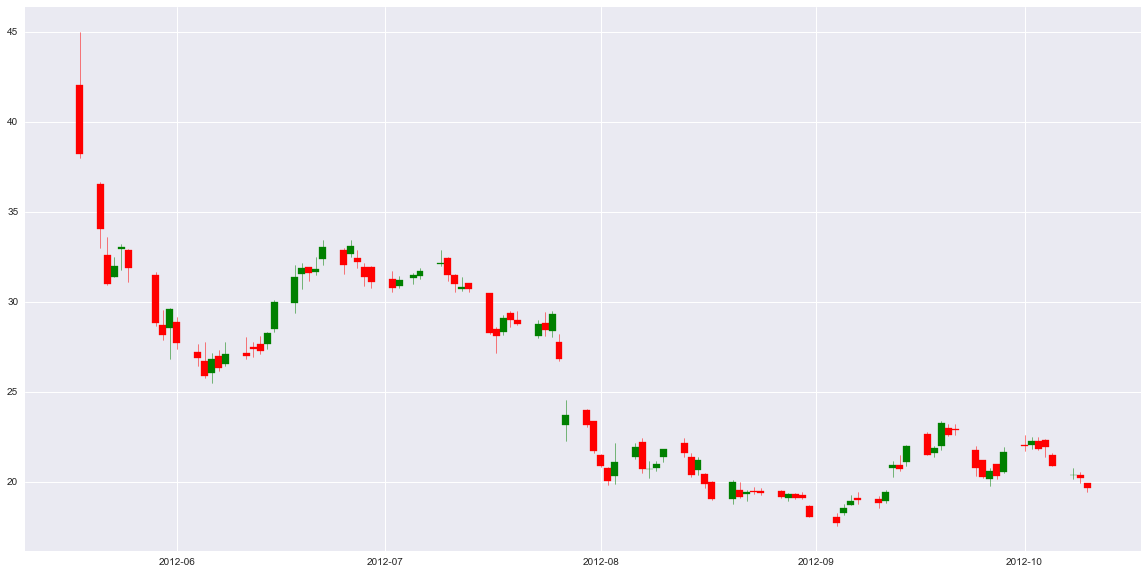

In [18]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

df = web.get_data_yahoo('FB', start='2012-01-01', end='2012-10-10')
df = df[['Open', 'High', 'Low', 'Close']]

df.reset_index(inplace=True)
df['Date'] = df['Date'].map(mdates.date2num)

#fig, ax1 = plt.subplots(figsize=(14,7))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

#ax = plt.subplot(figsize=(14,7))
candlestick_ohlc(ax, df.values, width=1, colorup='g', colordown='r')
ax.xaxis_date()
ax.grid(True)
plt.show()

# ax = plt.subplot()
# ax.grid(True)
# ax.set_axisbelow(True)
# ax.set_title('AAPL Share Price', color='white')
# ax.set_facecolor('black')
# ax.figure.set_facecolor('#121212')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.xaxis_date()

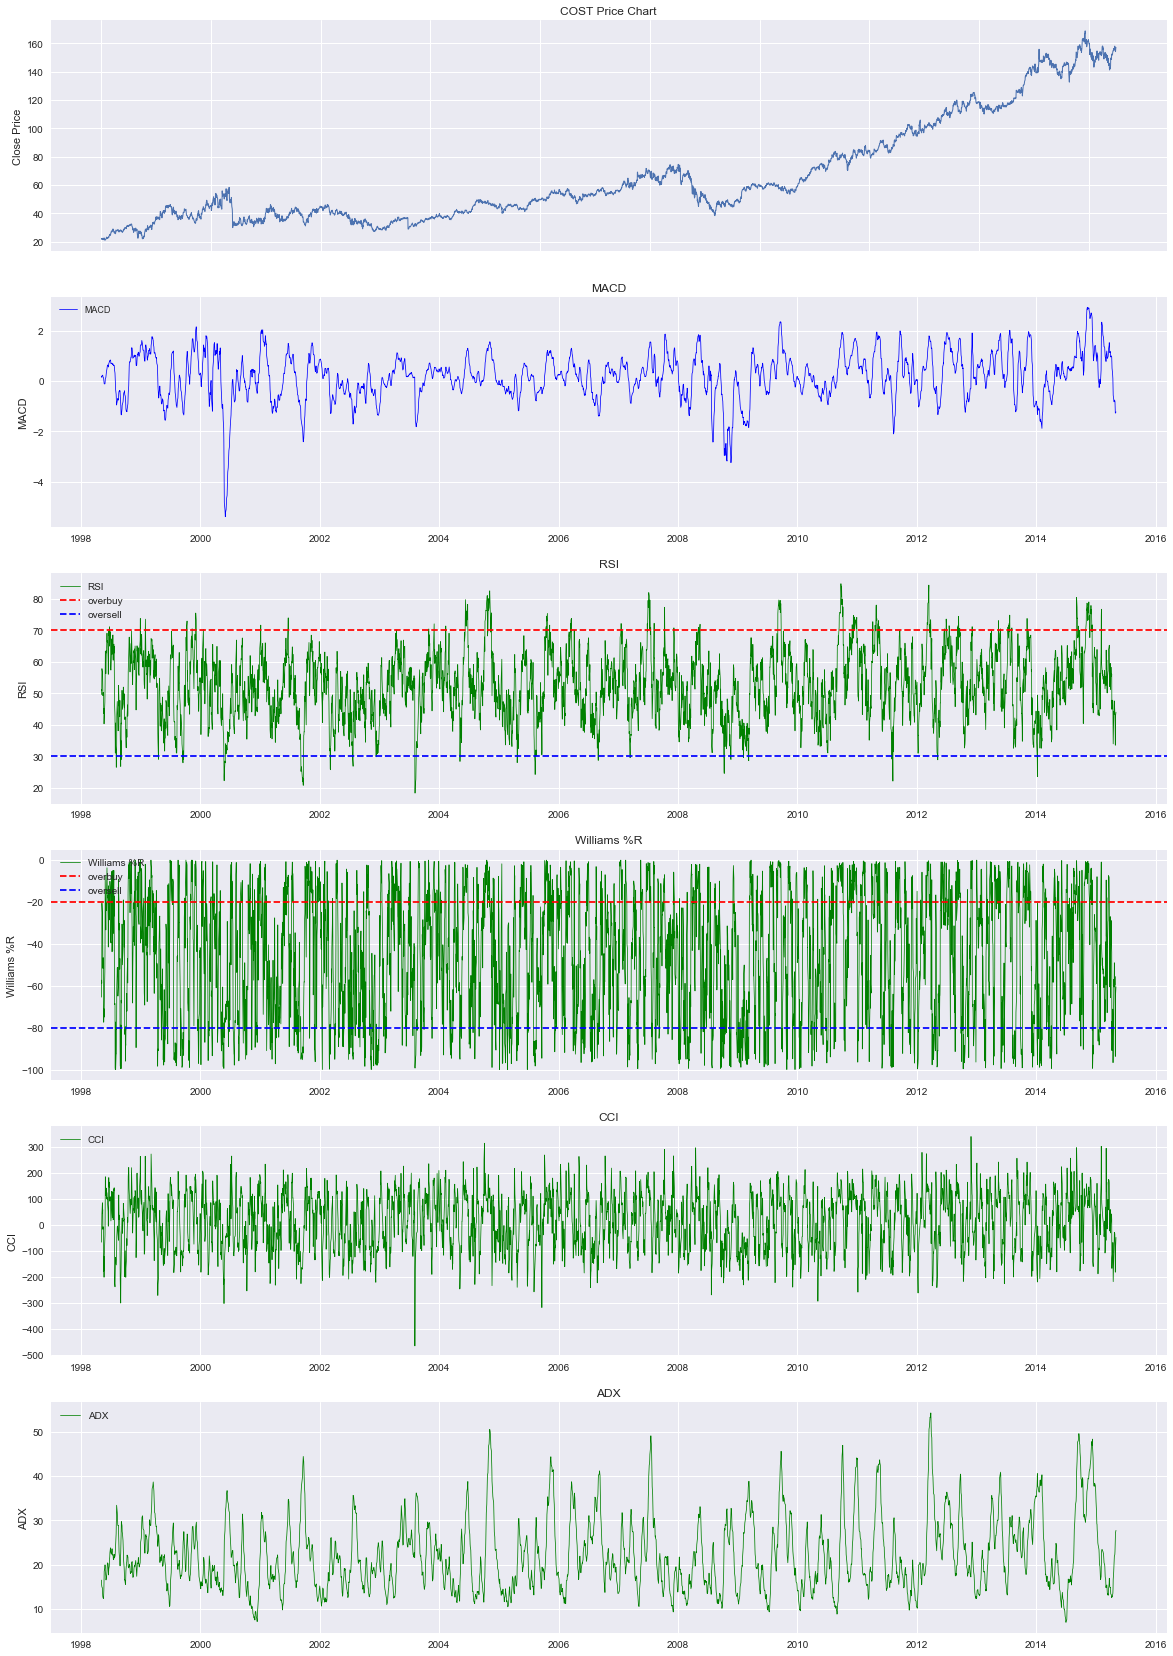

In [19]:
fig = plt.figure(figsize=(20,50))
ax = fig.add_subplot(10, 1, 1)
ax.set_xticklabels([])
plt.plot(stocks['COST']['close'],lw=1)
plt.title('COST Price Chart')
plt.ylabel('Close Price')
plt.grid(True)

bx = fig.add_subplot(10, 1, 2)
plt.plot(stocks_indicators['COST']['macd'],'b',lw=0.75,linestyle='-',label='MACD')
plt.title('MACD')
plt.legend(loc=2,prop={'size':9})
plt.ylabel('MACD')
plt.grid(True)

cx = fig.add_subplot(10, 1, 3)
plt.plot(stocks_indicators['COST']['rsi'],'g',lw=0.75,linestyle='-',label='RSI')
l1=plt.axhline(70,color='red',ls='--',label='overbuy')
l2=plt.axhline(30,color='blue',ls='--',label='oversell')
plt.title('RSI')
plt.legend(loc=2,prop={'size':10})
plt.ylabel('RSI')
plt.grid(True)

dx = fig.add_subplot(10, 1, 4)
plt.plot(stocks_indicators['COST']['willr'],'g',lw=0.75,linestyle='-',label='Williams %R')
l3=plt.axhline(-20,color='red',ls='--',label='overbuy')
l2=plt.axhline(-80,color='blue',ls='--',label='oversell')
plt.title('Williams %R')
plt.legend(loc=2,prop={'size':10})
plt.ylabel('Williams %R')
plt.grid(True)

dx = fig.add_subplot(10, 1, 5)
plt.plot(stocks_indicators['COST']['cci'],'g',lw=0.75,linestyle='-',label='CCI')
# l3=plt.axhline(-20,color='red',ls='--',label='overbuy')
# l2=plt.axhline(-80,color='blue',ls='--',label='oversell')
plt.title('CCI')
plt.legend(loc=2,prop={'size':10})
plt.ylabel('CCI')
plt.grid(True)

dx = fig.add_subplot(10, 1, 6)
plt.plot(stocks_indicators['COST']['adx'],'g',lw=0.75,linestyle='-',label='ADX')
# l3=plt.axhline(-20,color='red',ls='--',label='overbuy')
# l2=plt.axhline(-80,color='blue',ls='--',label='oversell')
plt.title('ADX')
plt.legend(loc=2,prop={'size':10})
plt.ylabel('ADX')
plt.grid(True)

In [20]:
stocks_indicators['JNJ'].head()

,sma_5,sma_10,mom_10,wma_10,wma_5,fastk,fastd,macd,rsi,willr,cci,adosc,atr,adx,obv,pct_change
Date,,,,,,,,,,,,,,,,
1998-05-05,35.20000,35.162500,-0.18750,35.137500,35.254167,49.333333,48.009768,-0.416956,44.865817,-50.666667,-14.527172,-1.277304e+06,0.850068,17.439337,9346800.0,0
1998-05-06,35.21250,35.059375,-1.03125,35.045455,35.072917,26.666667,44.444444,-0.442613,41.192041,-73.333333,-70.797721,-2.214380e+06,0.847385,17.228785,6334000.0,1
1998-05-07,35.01875,34.993750,-0.65625,34.994886,34.929167,33.802817,36.600939,-0.447699,42.387432,-66.197183,-73.414634,-2.603221e+06,0.824804,17.118505,10017000.0,1
1998-05-08,35.11250,35.018750,0.25000,35.098295,35.110417,69.014085,43.161189,-0.384260,49.321140,-30.985915,41.766290,-1.810300e+06,0.832853,15.936515,13514200.0,0
1998-05-11,35.05000,35.056250,0.37500,35.106250,35.093750,46.478873,49.765258,-0.370064,45.543349,-53.521127,45.901639,-2.312188e+06,0.864882,15.443126,9395600.0,1


In [21]:
len(stocks_indicators['COST'])

4277

In [22]:
def weighs_tabale(stocks, period):
    table = pd.DataFrame()
    for j in stocks:
        weighs_1 = []
        for i in range(1,period+1):
            stocks_indicators = get_indicators(stocks, i)
            weighs_1.append((len(stocks_indicators[j][stocks_indicators[j]['pct_change']=='1'])/\
                            float(len(stocks_indicators[j])))*100)
        table = pd.concat([table, pd.DataFrame(weighs_1)], axis=1)
    table.index = range(1,period+1)
    table.columns = stocks.keys()
    return table

In [23]:
table = weighs_tabale(stocks, 20)

In [24]:
table.head()

,AAPL,MSFT,COST,JNJ
1,51.905541,49.357026,50.058452,50.479308
2,53.238251,50.011690,52.069207,50.876783
3,54.570961,50.549451,52.840776,52.419921
4,55.552958,50.853402,54.009820,53.565583
5,56.418050,51.274258,54.570961,52.653729


## Model and Method
One of the advantages of random forests is that it does not strictly need parameter tuning. Random forests is an aggregation of another weaker machine learning model, decision trees. First, a bootstrapped sample is taken from the training set. Then, a random number of features are chosen to form a decision tree. Finally, each tree is trained and grown to the fullest extend possible without pruning. Those three steps are repeated n times form random decision trees. Each tree gives a classification and the classification that has the most votes is chosen. For the number of trees in the random forests, I chose 300 trees. I could go for a higher number but according to research, a larger number of trees does not always give better performance and only increases the computational cost (4). Since we will not be tuning the model’s parameters, we are only going to split the data to train and test set (no validation set). For the scores, I used the accuracy score and the f1 score. The accuracy score is simply the percentage (or fraction) of the instances correctly classified. The f1 score calculated by

F1=2precision×recallprecision+recall
precision=tptp+fp
recall=tptp+fn
where tp is the number of positive instances classifier as positive, fp is the number of negative instances classified as positive and fn is the number of positive instances classified as negative. Because of the randomness of the model, each train set is trained 5 times and the average of the scores on the test set is the final score. All of the calculation were done by python’s scikit-learn library.

## Building the Model: Random Forest

In [25]:
def avg_score(x_train, y_train,x_test,y_test,trees):
    accuracy = []
    f1 = []
    rf_model = RandomForestClassifier(trees)
    #for i in range(5):
    rf_model.fit(x_train,y_train)
    accuracy.append(rf_model.score(x_test,y_test))
    f1.append(f1_score(y_test,rf_model.predict(x_test), pos_label='1'))
    cm = confusion_matrix(y_test, rf_model.predict(x_test))
    avg_accuracy = sum(accuracy)/len(accuracy)
    avg_f1 = sum(f1)/len(f1)
    print(cm)
    return avg_accuracy, avg_f1, cm

In [26]:
train, test = train_test_split(stocks_indicators['COST'])
avg_score(train.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,:-1],test.iloc[:,-1],10)

[[328 215]
 [293 234]]


(0.525233644859813, 0.4795081967213115, array([[328, 215],
        [293, 234]], dtype=int64))

In [27]:
def accuracy(stocks, trees, period):
    table_accuracy = pd.DataFrame()
    table_f1 = pd.DataFrame()
    for j in stocks:
        accuracy_values = []
        f1_values = []
        for i in range(1,period+1):
            stocks_indicators = get_indicators(stocks, i)
            train, test = train_test_split(stocks_indicators[j])
            accuracy, f1, cm = avg_score(train.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,:-1],test.iloc[:,-1],trees)
            #cm = confusion_matrix(test.iloc[:,-1], rf_model.predict(x_test))
            accuracy_values.append(accuracy)
            f1_values.append(f1)
        table_accuracy = pd.concat([table_accuracy, pd.DataFrame({j : accuracy_values})], axis=1)
        table_f1 = pd.concat([table_f1, pd.DataFrame({j : f1_values})], axis=1)
    table_accuracy.index = range(1,period+1)
    table_f1.index = range(1,period+1)
    return table_accuracy, table_f1

## Model Evaluation: Confusion Matrix

In [28]:
accuracy_table, f1_table = accuracy(stocks, 10, 20)

[[284 237]
 [291 258]]
[[327 187]
 [218 338]]
[[286 186]
 [209 389]]
[[327 142]
 [183 418]]
[[334 145]
 [146 445]]
[[345 124]
 [134 467]]
[[360  87]
 [141 482]]
[[345  99]
 [144 482]]
[[368  94]
 [ 98 510]]
[[354  91]
 [100 525]]
[[344 100]
 [102 524]]
[[341  82]
 [110 537]]
[[356  88]
 [ 90 536]]
[[332  80]
 [ 96 562]]
[[375  67]
 [ 90 538]]
[[329  86]
 [ 84 571]]
[[333  90]
 [ 86 561]]
[[352  53]
 [ 89 576]]
[[350  70]
 [ 98 552]]
[[328  81]
 [ 94 567]]
[[333 223]
 [297 217]]
[[347 197]
 [270 256]]
[[412 123]
 [225 310]]
[[396 133]
 [198 343]]
[[410 128]
 [187 345]]
[[400 106]
 [166 398]]
[[406 102]
 [161 401]]
[[388 101]
 [166 415]]
[[416  88]
 [138 428]]
[[405  93]
 [137 435]]
[[395  86]
 [126 463]]
[[398  97]
 [137 438]]
[[398  94]
 [125 453]]
[[410  96]
 [117 447]]
[[403  79]
 [131 457]]
[[425  65]
 [135 445]]
[[431  98]
 [102 439]]
[[416  77]
 [117 460]]
[[385  66]
 [158 461]]
[[448  72]
 [115 435]]
[[335 185]
 [331 219]]
[[339 191]
 [237 303]]
[[331 168]
 [255 316]]
[[341 157]


In [29]:
accuracy_table

,AAPL,MSFT,COST,JNJ
1,0.506542,0.514019,0.517757,0.500000
2,0.621495,0.563551,0.600000,0.580374
3,0.630841,0.674766,0.604673,0.649533
4,0.696262,0.690654,0.663551,0.676636
5,0.728037,0.705607,0.689720,0.667290
6,0.758879,0.745794,0.716822,0.704673
7,0.786916,0.754206,0.715888,0.736449
8,0.772897,0.750467,0.741121,0.722430
9,0.820561,0.788785,0.728037,0.771028
10,0.821495,0.785047,0.753271,0.761682


In [30]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [31]:
accuracy_table.style.apply(highlight_max, axis=0)

,AAPL,MSFT,COST,JNJ
1,0.506542,0.514019,0.517757,0.5
2,0.621495,0.563551,0.6,0.580374
3,0.630841,0.674766,0.604673,0.649533
4,0.696262,0.690654,0.663551,0.676636
5,0.728037,0.705607,0.68972,0.66729
6,0.758879,0.745794,0.716822,0.704673
7,0.786916,0.754206,0.715888,0.736449
8,0.772897,0.750467,0.741121,0.72243
9,0.820561,0.788785,0.728037,0.771028
10,0.821495,0.785047,0.753271,0.761682


Text(0,0.5,'Average Score')

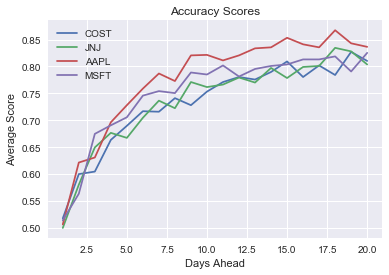

In [32]:
df1 = accuracy_table[['COST']]
df2 = accuracy_table[['JNJ']]
df3 = accuracy_table[['AAPL']]
df4 = accuracy_table[['MSFT']]
ax = df1.plot()
df2.plot(ax=ax, title='Accuracy Scores')
df3.plot(ax=ax, title='Accuracy Scores')
df4.plot(ax=ax, title='Accuracy Scores')
ax.set_xlabel("Days Ahead")
ax.set_ylabel("Average Score")

## Model Evaluation: F1 Table

In [33]:
f1_table.style.apply(highlight_max, axis=0)

,AAPL,MSFT,COST,JNJ
1,0.494253,0.454927,0.459119,0.46339
2,0.625347,0.522983,0.586074,0.546006
3,0.663257,0.640496,0.599052,0.639076
4,0.720069,0.674533,0.672131,0.684307
5,0.753599,0.686567,0.716724,0.659656
6,0.783557,0.745318,0.731145,0.713768
7,0.808725,0.753052,0.732865,0.733962
8,0.798674,0.756609,0.766245,0.726771
9,0.841584,0.791128,0.753181,0.777475
10,0.846092,0.790909,0.772414,0.783347


In [38]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,7))
# plt.plot(accuracy_table)
# plt.title('Accuracy Scores')
# plt.xlabel('Days Ahead')
# plt.ylabel('Average Score')
# plt.legend();

Text(0,0.5,'Average Score')

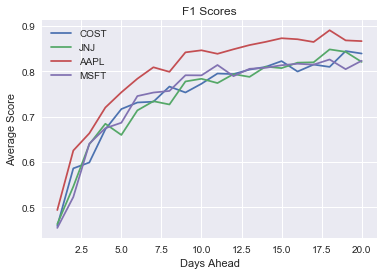

In [34]:
df1 = f1_table[['COST']]
df2 = f1_table[['JNJ']]
df3 = f1_table[['AAPL']]
df4 = f1_table[['MSFT']]
ax = df1.plot()
df2.plot(ax=ax, title='F1 Scores')
df3.plot(ax=ax, title='F1 Scores')
df4.plot(ax=ax, title='F1 Scores')
ax.set_xlabel("Days Ahead")
ax.set_ylabel("Average Score")

In [35]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,7))
# plt.plot(f1_table)
# plt.title('F1 Scores')
# plt.xlabel('Days Ahead')
# plt.ylabel('Average Score')
# plt.legend();

## Building the Model: Extreme Gradient Boosting (XG Boost)

In [66]:
from xgboost import XGBClassifier

def avg_score_xg(x_train, y_train,x_test,y_test,trees):
    accuracy_xg = []
    f1_xg = []
    xg_model = XGBClassifier(trees)
    xg_model.fit(x_train,y_train)
    accuracy_xg.append(xg_model.score(x_test,y_test))
    f1_xg.append(f1_score(y_test,xg_model.predict(x_test), pos_label='1'))
    cm_xg = confusion_matrix(y_test, xg_model.predict(x_test))
    avg_accuracy_xg = sum(accuracy_xg)/len(accuracy_xg)
    avg_f1_xg = sum(f1_xg)/len(f1_xg)
    return avg_accuracy_xg, avg_f1_xg

In [67]:
train, test = train_test_split(stocks_indicators['COST'])
avg_score_xg(train.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,:-1],test.iloc[:,-1],10)

(0.5261682242990654, 0.5301204819277108)

In [72]:
def accuracy_xg(stocks, trees, period):
    table_accuracy_xg = pd.DataFrame()
    table_f1_xg = pd.DataFrame()
    for j in stocks:
        accuracy_values_xg = []
        f1_values_xg = []
        for i in range(1,period+1):
            stocks_indicators = get_indicators(stocks, i)
            train, test = train_test_split(stocks_indicators[j])
            accuracy_xg, f1_xg = avg_score_xg(train.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,:-1],test.iloc[:,-1],trees)
            accuracy_values_xg.append(accuracy)
            f1_values_xg.append(f1_xg)
        table_accuracy_xg = pd.concat([table_accuracy_xg, pd.DataFrame({j : accuracy_values_xg})], axis=1)
        table_f1_xg = pd.concat([table_f1_xg, pd.DataFrame({j : f1_values_xg})], axis=1)
    table_accuracy_xg.index = range(1,period+1)
    table_f1_xg.index = range(1,period+1)
    return table_accuracy_xg, table_f1_xg

In [73]:
accuracy_table_xg, f1_table_xg = accuracy_xg(stocks, 10, 20)

In [74]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [75]:
f1_table_xg.style

,AAPL,MSFT,COST,JNJ
1,0.555556,0.47591,0.512351,0.534653
2,0.66443,0.570878,0.612457,0.638413
3,0.708402,0.688827,0.670103,0.692927
4,0.74092,0.736185,0.727572,0.734375
5,0.78515,0.743891,0.757377,0.752228
6,0.781628,0.769094,0.751634,0.756432
7,0.83153,0.788707,0.777152,0.787252
8,0.847148,0.815878,0.782324,0.794425
9,0.820233,0.83085,0.797417,0.819618
10,0.84343,0.850258,0.794544,0.800334


In [76]:
f1_table_xg.style.apply(highlight_max, axis=0)

,AAPL,MSFT,COST,JNJ
1,0.555556,0.47591,0.512351,0.534653
2,0.66443,0.570878,0.612457,0.638413
3,0.708402,0.688827,0.670103,0.692927
4,0.74092,0.736185,0.727572,0.734375
5,0.78515,0.743891,0.757377,0.752228
6,0.781628,0.769094,0.751634,0.756432
7,0.83153,0.788707,0.777152,0.787252
8,0.847148,0.815878,0.782324,0.794425
9,0.820233,0.83085,0.797417,0.819618
10,0.84343,0.850258,0.794544,0.800334


Text(0,0.5,'Average Score')

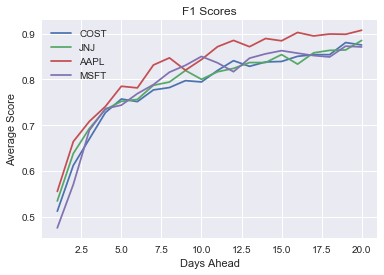

In [77]:
df1 = f1_table_xg[['COST']]
df2 = f1_table_xg[['JNJ']]
df3 = f1_table_xg[['AAPL']]
df4 = f1_table_xg[['MSFT']]
ax = df1.plot()
df2.plot(ax=ax, title='F1 Scores')
df3.plot(ax=ax, title='F1 Scores')
df4.plot(ax=ax, title='F1 Scores')
ax.set_xlabel("Days Ahead")
ax.set_ylabel("Average Score")

## Conclusion
As seen from the "Accuracy Score" and "F1 Score" above, we get poor results for small number of days ahead (from 1 to 4) and greater results as the number of days ahead increases afterworlds. For almost all the stocks for both scores, the highest scores are in the range of 17 to 20-days ahead.

We got satisfying results with ten technical indicators when predicting the price movement mostly within 14 to 20 days ahead witch scores ranging from 0.78 to 0.84 for the accuracy scores and from 0.76 to 0.87 for the f1 scores. We probably could have better results if we add more features that includes fundamentals and macro economic variables. Also, since commodities are highly leveraged, we could use minute by minute data to predict the movement of commodity prices at the end of the day. Actually this was my initial choice of data. But I could not find a source that provides minute by minute data for free.